# Example 1, Lindeborg Gård : running various scenarios
In this notebook, we define and run various simulations of Lindeborg's energy system.

Some imports...

In [1]:
import sys, os, re
# add module directory to system path, relative
sys.path.insert(0, os.path.join('..', 'farm_biochar_model'))
# add module directory to system path, absolute
sys.path.insert(0, os.path.join(os.getcwd(),'..', 'farm_biochar_model')) 

# import components of farm_biochar_model
import farm_demand as fd # energy demand
import farm_supply as fs # energy supply
import farm_ficus as ff # unit commitment solver
import farm_bw2 as fb # life cycle analysis

# other libraries (in environment)
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

Some folder and file paths...

In [2]:
# absolute folder path
afp = 'C:/Users/eazzi/Box Sync/KTH_PhD_HeavyData/P2_farm_biochar'
# example folder name
ex = '/ex1_Lindeborg'

# Input files that are used...
## SMHI Weather data
smhi_folder = afp+ex+'/input_files/'
smhi_files=['smhi-opendata_1_86420_20190321_121405.csv', 'smhi-opendata_1_86420_20190321_121419.csv']

## Energy Plants data
plants_folder= afp+'/farm_biochar_model/'
plants_file= 'farm_supply_plants.xlsx'

## Electricity Mix Emission Factor
el_folder = afp+ex+'/input_files/'
el_file='powermix-se.xlsx'
el_tab = 'powermix-se_2018'


# Output files that will be generated...
## Ficus input model (generated)
ficus_files = ex+'/output_files/' #will be saved in..

## Ficus result (generated)
ficus_result_folder = afp+ex+'/output_files' #will be saved in..

# See ficus documentation, for details https://ficus.readthedocs.io/

# bw2 path to db, only if project is new
ei_name = "ecoinvent 3.3 cutoff"
ei_path = "C:\\Users\\eazzi\\Box Sync\\KTH_PhD_HeavyData\\ecoinvent_3.3_cutoff_ecoSpold02\\datasets\\"

# bw2 project name and scenario_prefix_activity
proj="cs1_Lindeborgs"
fg_db = "farmEnergySystem"


## Simple model run: one technology, one year

Define parameters of the simulation...

Unless re-defined in the next simulations, the parameters defined here are the ones used in all simulations.

In [3]:
# Scenario name
scenario = 'playing_around'
# Year to study
year='2017'
calendar=False

# Heating demand
ref_year= ['1996', '2010'] #'2017' # Heat demand reference year
T_max = 17 # Outdoor temperature above which no heating is required

# Building properties
##Case 3: mixed declarations, new building bioenergy, old-ones on electricity
a = np.array([400, 150, 90]) # New values; 89 = A_temp from Boverket; 140 = based on bo+bi area online; 400 : Carl + Maps check
w = np.array([0.08, 0.065, 0.05])# share hot water
e = np.array([90, 154*1.6, 154*1.6]) #kWh/m2/yr, from Boverket, electricity input PEF-corrected (new Boverket norm)
c = np.array([1/1.6*3, 1/1.6*3, 1/1.6*3]) # /PEF *COP # conversion fuel input to final heat

# Annual electrical demand
elec_yr = 11000 # kWh

# Plants of interest, for the scenario
plantsAvailable = ['pyrBMC50t', 'el. heater', 'hp'] # select among list in plants_file # BioGreen60

# Time steps [ficus]
tb = 3600*24 # s, e.g. hourly = 3600; monthly = 3600*730 (h/month); daily = 3600*24 
tb_start = 1 # interval for optimisation, 1..365 = full year
tb_end = 365 # # e.g. daily, 365 = last day of the year

# List of commodities [ficus]
commodities_imp = ['elec', 'pellets'] # importable commodities
commodities_exp = ['elec', 'biochar'] # exportable commodities
commodities = commodities_imp + list(set(commodities_exp) - set(commodities_imp)) # all commodities, unique list
import_max = ['inf', 'inf', 0] # in order as commodities
export_max = ['inf', 0, 'inf'] 

# Emission factor for commodities other than electricity
## Pellets
ef_pellets = 0.13286474045379412 # market for wood pellets, RER kg CO2/kg dry pellets
LHV_pellets = 18/3.6 # kWh/kg dry pellets
ef_pellets = ef_pellets / LHV_pellets *1000 # gCO2/kWh dry pellets
## Biochar
biochar_seq = 0.8*0.8*44/12*1000 # gCO2/kg biochar; biochar is not in kWh but in kg of biochar; we assume 80% C with 80% remaining after 100y

# Input Ficus file names, scenario names
ficus_scenario = scenario+'.xlsx'

# Output Ficus 
result_name = os.path.splitext(os.path.split(afp+ficus_files+ficus_scenario)[1])[0]
#resultfile = os.path.join(ficus_result_folder, 'result-{}.xlsx'.format(result_name))

# ficus output folder to bw2
p2e=tb/3600 # 24h, conversion from kW to kWh

# ficus input folder to bw2
processes = plantsAvailable


# bw2 project name and scenario_prefix_activity
act_suffix= scenario
fu_name= "farmEnergy_"+act_suffix

In [4]:
farm_demand = fd.run_scn_demand(smhi_folder, smhi_files,
                                areas=a, energiprestande=e, water_share=w, cop_corr=c,
                                ref_year=ref_year, T_max=T_max, cc=False, cc_scen=False)

Parsing SMHI weather data: smhi-opendata_1_86420_20190321_121405.csv
Parsing SMHI weather data: smhi-opendata_1_86420_20190321_121419.csv
Total heat demand is  178380.0  kWh of which 6.717961654894046 % hot water
Reference year:  ['1996', '2010']
Building heating signature:  -1.6587481186847277  kW/K
Average yearly degreedays:  -100314.50714285717  degree-hour/year
Returning farm_demand DataFrame


In [18]:
# plants parsed and ficus file written
farm_supply = fs.run_scn_ficus_writer(plants_folder, plants_file,
                                      tb, tb_start, tb_end, 
                                      calendar,
                                      commodities_imp, commodities_exp, import_max, export_max, 
                                      el_folder, el_file, el_tab, 
                                      ef_pellets, biochar_seq, 
                                      plantsAvailable, farm_demand, year, elec_yr,
                                      afp, ficus_files, scenario)

# create output folder for that file
result_dir = ff.prepare_result_directory(afp+ex+'/output_files', scenario)

Parsing sample_plants
Calculating data for ficus input folder
Writing ficus input file


In [17]:
# run ficus unit commitment
prob = ff.run_ficus(afp+ficus_files+scenario+'.xlsx', opt = 'cplex', MipGap = 0)

# saving ficus report and figures
ff.report(prob, result_dir)
ff.result_figures(result_dir,prob=prob, show=False)

Read Data ...

Data Read. time: 0.1 s

Prepare Data ...

Data Prepared. time: 0.1 s

Define Model ...

Model Defined. time: 10.3 s

Solve Model ...


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 12.8.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2017.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\eazzi\AppData\Local\Temp\tmposw5avwu.cplex.log' open.
CPLEX> New value for default parallel thread count: 2
CPLEX> Problem 'C:\Users\eazzi\AppData\Local\Temp\tmp947yyy5q.pyomo.lp' read.
Read time = 0.03 sec. (2.70 ticks)
CPLEX> Problem name         : C:\Users\eazzi\AppData\Local\Temp\tmp947yyy5q.pyomo.lp
Objective sense      : Minimize
Variables            :   12809  [Nneg: 8783,  Free: 2928,  Binary: 1098]
Objective nonzeros   :       8


In [6]:
result_dir = ff.prepare_result_directory(afp+ex+'/output_files', scenario)

In [8]:
# printing final report and bw2-LCA
lci_t, lcia_t = fb.run_scn_bw2(result_dir, 'result-'+scenario+'.xlsx',
                               year, calendar, p2e, plantsAvailable,
                               afp, ficus_files, scenario,
                               proj, fg_db, fresh_db=False, plantEmissions=True, plantManufacturing=True, show_plot = False)

Biochar produced annually:  biochar_production    7.978247
dtype: float64  tons
Compile ficus lci and lcia
-12.079510330862032 ton CO2-eq, net score, for 1 year of farm-energy
Towards bw2...
bw2# Add production processes, manufacturing, and start-ups
bw2# Add technosphere and biosphere flows to each production process
## bw2 Calculate apparent mix for ... pyrBMC50t
## bw2 Calculate apparent mix for ... el. heater
## bw2 Calculate apparent mix for ... hp
Current project is:  cs1_Lindeborgs
Read only mode:  False


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 03/18/2020 18:47:00
  Finished: 03/18/2020 18:47:00
  Total time elapsed: 00:00:00
  CPU %: 85.10
  Memory %: 1.82
Scenario  playing_around  is now ready for analysis in Activity-Browser


## Simulation A) Series of year, with BioMaCon50kW
### First without climate change
Simulation A in manuscript: model run for several years, to estimate variability and trend in Lindeborg's biochar production

In [ ]:
farm_demand = fd.run_scn_demand(smhi_folder, smhi_files,
                                areas=a, energiprestande=e, water_share=w, cop_corr=c,
                                ref_year=ref_year, T_max=T_max, cc=False, cc_scen=False)

In [7]:
years = ['2000','2001', '2002','2003','2004','2005','2006','2007','2008','2009', '2010','2011','2012',
         '2013','2014','2015','2016','2017']
plantsAvailable = ['pyrBMC50t', 'el. heater', 'hp'] # select among list in plants_file

# 2010 >>> https://en.wikipedia.org/wiki/2010_Swedish_cold_waves
for year in years:
    calendar=False
    monthday = ['-01-01','-12-31'] if calendar else ['-08-01','-07-31']
    year_txt = [year, year] if calendar else [year, str(int(year)+1)]
    tmp = fs.selectInterval(farm_demand.resample('D').mean(), year_txt[0]+monthday[0], year_txt[1]+monthday[1])
    print(year, '>>> ', tmp.sum().sum()*p2e, ' kWh/yr')
    
    scenario = 'BioMaCon50kW_PL5MO7_loop_'+year #'BioMaCon50kW_PL5MO7MWh186_loop_'+year
    # to run scenario with different PL (part-load) or MO (min-operation time), 
    # edit the plant properties in the Excel file and name scenario differently
    # alternatively, create new plant-processes, and change the list plantsAvailable
    
    # plants parsed and ficus file written
    farm_supply = fs.run_scn_ficus_writer(plants_folder, plants_file,
                                          tb, tb_start, tb_end, 
                                          calendar,
                                          commodities_imp, commodities_exp, import_max, export_max, 
                                          el_folder, el_file, el_tab, 
                                          ef_pellets, biochar_seq, 
                                          plantsAvailable, farm_demand, year, elec_yr,
                                          afp, ficus_files, scenario)
    # run ficus milp
    prob = ff.run_ficus(afp+ficus_files+scenario+'.xlsx', opt = 'cplex', MipGap = 0)

    # saving ficus report and figures
    result_dir = ff.prepare_result_directory(afp+ex+'/output_files', scenario)
    ff.report(prob, result_dir)
    ff.result_figures(result_dir,prob=prob, show=False)
    # printing final report and bw2-LCA
    
    lci_t, lcia_t = fb.run_scn_bw2(result_dir, 'result-'+scenario+'.xlsx',
                                    year, calendar, p2e, plantsAvailable,
                                    afp, ficus_files, scenario,
                                    proj, fg_db, fresh_db=False,
                                    plantEmissions=True, plantManufacturing=True, show_plot = False)

2000 >>>  162736.9185057321  kWh/yr
Parsing sample_plants
Calculating data for ficus input folder
Writing ficus input file


C:\Users\eazzi\AppData\Local\conda\conda\envs\bw2\lib\site-packages\openpyxl\worksheet\_reader.py:296: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\Users\eazzi\AppData\Local\conda\conda\envs\bw2\lib\site-packages\openpyxl\worksheet\_reader.py:296: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


Read Data ...

Data Read. time: 0.2 s

Prepare Data ...

Data Prepared. time: 0.1 s

Define Model ...

Model Defined. time: 10.8 s

Solve Model ...


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 12.8.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2017.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\eazzi\AppData\Local\Temp\tmpfvrsp811.cplex.log' open.
CPLEX> New value for default parallel thread count: 2
CPLEX> Problem 'C:\Users\eazzi\AppData\Local\Temp\tmp0w3rg7xl.pyomo.lp' read.
Read time = 0.03 sec. (2.70 ticks)
CPLEX> Problem name         : C:\Users\eazzi\AppData\Local\Temp\tmp0w3rg7xl.pyomo.lp
Objective sense      : Minimize
Variables            :   12809  [Nneg: 8783,  Free: 2928,  Binary: 1098]
Objective nonzeros   :       8


C:\Users\eazzi\Box Sync\KTH_PhD_HeavyData\P2_farm_biochar\ex1_Lindeborg\..\farm_biochar_model\farm_ficus.py:2202: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  sp_crtd = ax0.stackplot(step_edit_x(created.index), step_edit_y(created.as_matrix().T), linewidth=0.15)
C:\Users\eazzi\Box Sync\KTH_PhD_HeavyData\P2_farm_biochar\ex1_Lindeborg\..\farm_biochar_model\farm_ficus.py:2212: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  sp_csmd = ax0.stackplot(step_edit_x(consumed.index), step_edit_y(-consumed.as_matrix().T), linewidth=0.15)
C:\Users\eazzi\AppData\Local\conda\conda\envs\bw2\lib\site-packages\matplotlib\tight_layout.py:181: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. '


Biochar produced annually:  biochar_production    6.524784
dtype: float64  tons
Compile ficus lci and lcia
-9.42868539672138 ton CO2-eq, net score, for 1 year of farm-energy
Towards bw2...
bw2# Add production processes, manufacturing, and start-ups
bw2# Add technosphere and biosphere flows to each production process
## bw2 Calculate apparent mix for ... pyrBMC50t
## bw2 Calculate apparent mix for ... el. heater
## bw2 Calculate apparent mix for ... hp
Current project is:  cs1_Lindeborgs
Read only mode:  False


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 03/18/2020 17:14:08
  Finished: 03/18/2020 17:14:09
  Total time elapsed: 00:00:00
  CPU %: 70.50
  Memory %: 2.06
Scenario  BioMaCon50kW_PL5MO7_loop_2000  is now ready for analysis in Activity-Browser
2001 >>>  156251.0698335508  kWh/yr
Parsing sample_plants
Calculating data for ficus input folder
Writing ficus input file
Read Data ...

Data Read. time: 0.1 s

Prepare Data ...

Data Prepared. time: 0.1 s

Define Model ...

Model Defined. time: 11.1 s

Solve Model ...


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 12.8.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2017.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\eazzi\AppData\Local\Temp\tmpznz4urfu.cplex.log' open.
CPLEX

C:\Users\eazzi\AppData\Local\conda\conda\envs\bw2\lib\site-packages\matplotlib\tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


Biochar produced annually:  biochar_production    5.96582
dtype: float64  tons
Compile ficus lci and lcia
-8.29838556293427 ton CO2-eq, net score, for 1 year of farm-energy
Towards bw2...
bw2# Add production processes, manufacturing, and start-ups
bw2# Add technosphere and biosphere flows to each production process
## bw2 Calculate apparent mix for ... pyrBMC50t
## bw2 Calculate apparent mix for ... el. heater
## bw2 Calculate apparent mix for ... hp
Current project is:  cs1_Lindeborgs
Read only mode:  False


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 03/18/2020 17:14:59
  Finished: 03/18/2020 17:14:59
  Total time elapsed: 00:00:00
  CPU %: 72.30
  Memory %: 2.23
Scenario  BioMaCon50kW_PL5MO7_loop_2001  is now ready for analysis in Activity-Browser


### Then, with climate change in Sweden
Below, with climate change effect on future heat demand

In [8]:
farm_demand = fd.run_scn_demand(smhi_folder, smhi_files,
                                areas=a, energiprestande=e, water_share=w, cop_corr=c,
                                ref_year=ref_year, T_max=T_max, 
                                cc=True, cc_scen=[2,1.5,1.5,1.25])
# [3,3,3,3] [2,2,2,2] [1,1,1,1] [0,0,0,0] / [1.5,1.5,1.5,1.5] 
#Heating_kW    1.738662e+06  1.910015e+06  2.088681e+06  2.273893e+06
#Water_kW      1.657804e+05  1.657804e+05  1.657804e+05  1.657804e+05

Parsing SMHI weather data: smhi-opendata_1_86420_20190321_121405.csv
Parsing SMHI weather data: smhi-opendata_1_86420_20190321_121419.csv
Total heat demand is  178380.0  kWh of which 6.717961654894046 % hot water
Reference year:  ['1996', '2010']
Building heating signature:  -1.6587481186847277  kW/K
Average yearly degreedays:  -100314.50714285717  degree-hour/year
Returning farm_demand DataFrame


And re-run the loop from #2.1, with different name

In [9]:
years = ['2000','2001',]
         #'2002','2003','2004','2005','2006','2007','2008','2009', '2010','2011','2012',
         #'2013','2014','2015','2016','2017','2018']
plantsAvailable = ['pyrBMC50t', 'el. heater', 'hp'] # select among list in plants_file

for year in years:
    calendar=False
    monthday = ['-01-01','-12-31'] if calendar else ['-08-01','-07-31']
    year_txt = [year, year] if calendar else [year, str(int(year)+1)]
    tmp = fs.selectInterval(farm_demand.resample('D').mean(), year_txt[0]+monthday[0], year_txt[1]+monthday[1])
    print(year, '>>> ', tmp.sum().sum()*p2e, ' kWh/yr')
    scenario = 'BioMaCon50kW_PL5MO7_loop_cc_'+year

    # plants parsed and ficus file written
    farm_supply = fs.run_scn_ficus_writer(plants_folder, plants_file,
                                          tb, tb_start, tb_end, 
                                          calendar,
                                          commodities_imp, commodities_exp, import_max, export_max, 
                                          el_folder, el_file, el_tab, 
                                          ef_pellets, biochar_seq, 
                                          plantsAvailable, farm_demand, year, elec_yr,
                                          afp, ficus_files, scenario)
    # run ficus milp
    prob = ff.run_ficus(afp+ficus_files+scenario+'.xlsx', opt = 'cplex', MipGap = 0)

    # saving ficus report and figures
    result_dir = ff.prepare_result_directory(afp+ex+'/output_files', scenario)
    ff.report(prob, result_dir)
    ff.result_figures(result_dir,prob=prob, show=False)
    # printing final report and bw2-LCA
    
    lci_t, lcia_t = fb.run_scn_bw2(result_dir, 'result-'+scenario+'.xlsx',
                                    year, calendar, p2e, plantsAvailable,
                                    afp, ficus_files, scenario,
                                    proj, fg_db, fresh_db=False,
                                    plantEmissions=True, plantManufacturing=True, show_plot = False)

2000 >>>  142736.2709807834  kWh/yr
Parsing sample_plants
Calculating data for ficus input folder
Writing ficus input file
Read Data ...

Data Read. time: 0.1 s

Prepare Data ...

Data Prepared. time: 0.1 s

Define Model ...

Model Defined. time: 10.9 s

Solve Model ...


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 12.8.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2017.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\eazzi\AppData\Local\Temp\tmpld4fhfxd.cplex.log' open.
CPLEX> New value for default parallel thread count: 2
CPLEX> Problem 'C:\Users\eazzi\AppData\Local\Temp\tmprth72fb0.pyomo.lp' read.
Read time = 0.03 sec. (2.70 ticks)
CPLEX> Problem name         : C:\Users\eazzi\AppData\Local\Temp\tmprth72fb0.pyomo.lp
Objective sen

Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 03/18/2020 17:19:01
  Finished: 03/18/2020 17:19:01
  Total time elapsed: 00:00:00
  CPU %: 94.00
  Memory %: 2.11
Scenario  BioMaCon50kW_PL5MO7_loop_cc_2000  is now ready for analysis in Activity-Browser
2001 >>>  136612.39905806936  kWh/yr
Parsing sample_plants
Calculating data for ficus input folder
Writing ficus input file
Read Data ...

Data Read. time: 0.1 s

Prepare Data ...

Data Prepared. time: 0.1 s

Define Model ...

Model Defined. time: 10.6 s

Solve Model ...


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 12.8.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2017.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\eazzi\AppData\Local\Temp\tmphpwwyx0d.cplex.log' open.
C

Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 03/18/2020 17:19:55
  Finished: 03/18/2020 17:19:55
  Total time elapsed: 00:00:00
  CPU %: 84.20
  Memory %: 2.24
Scenario  BioMaCon50kW_PL5MO7_loop_cc_2001  is now ready for analysis in Activity-Browser


## Simulation B) Comparing technologies, for a given year
Simulation B in manuscript: model run for single year, but with 6 different technologies, for compartive life cycle assessment

In [6]:
farm_demand = fd.run_scn_demand(smhi_folder, smhi_files,
                                areas=a, energiprestande=e, water_share=w, cop_corr=c,
                                ref_year=ref_year, T_max=T_max, cc=False, cc_scen=False)

Parsing SMHI weather data: smhi-opendata_1_86420_20190321_121405.csv
Parsing SMHI weather data: smhi-opendata_1_86420_20190321_121419.csv
Total heat demand is  178380.0  kWh of which 6.717961654894046 % hot water
Reference year:  ['1996', '2010']
Building heating signature:  -1.6587481186847277  kW/K
Average yearly degreedays:  -100314.50714285717  degree-hour/year
Returning farm_demand DataFrame


In [7]:
# name scenarios
scen_list = ['B1_Pyr-HP-el_', # base case pyr
             'B2_Pyr-el_',
             'B3_Pyr30-HP-el_',
             'B4_Comb-HP-el_',
             'B5_GSHP30_el_',
             'B6_el_']

# what differs between scenarios
ofInterest_list = [
    ['pyrBMC50t', 'hp', 'el. heater'],
    ['pyrBMC50t', 'el. heater'],
    ['pyrBMC30t', 'hp', 'el. heater'],
    ['comb', 'hp','el. heater'],
    ['gshp30', 'el. heater'], 
    ['el. heater'],
]

year = '2017'
calendar=False

In [9]:
print("Writing the ficus files for all scenarios...")
for i in range(3, len(scen_list)):    
    print(scen_list[i], ofInterest_list[i], year)
    scenario = 'cpLCA_50kW_PL5MO7_'+scen_list[i]+year
    plantsAvailable=ofInterest_list[i]
    # plants parsed and ficus file written
    if 'pyr' not in plantsAvailable[0]:
        commodities_imp = ['elec', 'pellets'] # importable commodities
        commodities_exp = ['elec',] # exportable commodities
        commodities = commodities_imp + list(set(commodities_exp) - set(commodities_imp)) # all commodities, unique list
        import_max = ['inf', 'inf'] # in order as commodities
        export_max = ['inf', 0] 
    else:
        commodities_imp = ['elec', 'pellets'] # importable commodities
        commodities_exp = ['elec', 'biochar'] # exportable commodities
        commodities = commodities_imp + list(set(commodities_exp) - set(commodities_imp)) # all commodities, unique list
        import_max = ['inf', 'inf', 0] # in order as commodities
        export_max = ['inf', 0, 'inf'] 
        
    farm_supply = fs.run_scn_ficus_writer(plants_folder, plants_file,
                                          tb, tb_start, tb_end, 
                                          calendar,
                                          commodities_imp, commodities_exp, import_max, export_max, 
                                          el_folder, el_file, el_tab, 
                                          ef_pellets, biochar_seq, 
                                          plantsAvailable, farm_demand, year, elec_yr,
                                          afp, ficus_files, scenario)

Writing the ficus files for all scenarios...
B4_Comb-HP-el_ ['comb', 'hp', 'el. heater'] 2017
Parsing sample_plants
Calculating data for ficus input folder
Writing ficus input file
B5_GSHP30_el_ ['gshp30', 'el. heater'] 2017
Parsing sample_plants
Calculating data for ficus input folder
Writing ficus input file
B6_el_ ['el. heater'] 2017
Parsing sample_plants
Calculating data for ficus input folder
Writing ficus input file
Time to adjust the ficus files... (no biochar cases)


In [10]:
print("Running the optimisation and analysis...")
for i in range(5,len(scen_list)):
    print(scen_list[i], ofInterest_list[i], year)
    # run ficus milp
    scenario = 'cpLCA_50kW_PL5MO7_'+scen_list[i]+year
    plantsAvailable=ofInterest_list[i]
    
    # run ficus milp
    prob = ff.run_ficus(afp+ficus_files+scenario+'.xlsx', opt = 'cplex', MipGap = 0)

    # saving ficus report and figures
    result_dir = ff.prepare_result_directory(afp+ex+'/output_files', scenario)
    ff.report(prob, result_dir)
    ff.result_figures(result_dir,prob=prob, show=False)
    
    # printing final report and bw2-LCA
    lci_t, lcia_t = fb.run_scn_bw2(result_dir, 'result-'+scenario+'.xlsx',
                                    year, calendar, p2e, plantsAvailable,
                                    afp, ficus_files, scenario,
                                    proj, fg_db, fresh_db=False,
                                    plantEmissions=True, plantManufacturing=True, show_plot = False)

Running the optimisation and analysis...
B6_el_ ['el. heater'] 2017
Read Data ...

Data Read. time: 0.1 s

Prepare Data ...

Data Prepared. time: 0.0 s

Define Model ...

Model Defined. time: 1.4 s

Solve Model ...


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 12.8.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2017.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\eazzi\AppData\Local\Temp\tmpucjyolzx.cplex.log' open.
CPLEX> New value for default parallel thread count: 2
CPLEX> Problem 'C:\Users\eazzi\AppData\Local\Temp\tmpz5pwplr_.pyomo.lp' read.
Read time = 0.02 sec. (0.37 ticks)
CPLEX> Problem name         : C:\Users\eazzi\AppData\Local\Temp\tmpz5pwplr_.pyomo.lp
Objective sense      : Minimize
Variables            :    2943  [Nneg

C:\Users\eazzi\Box Sync\KTH_PhD_HeavyData\P2_farm_biochar\ex1_Lindeborg\..\farm_biochar_model\farm_ficus.py:2202: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  sp_crtd = ax0.stackplot(step_edit_x(created.index), step_edit_y(created.as_matrix().T), linewidth=0.15)
C:\Users\eazzi\Box Sync\KTH_PhD_HeavyData\P2_farm_biochar\ex1_Lindeborg\..\farm_biochar_model\farm_ficus.py:2212: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  sp_csmd = ax0.stackplot(step_edit_x(consumed.index), step_edit_y(-consumed.as_matrix().T), linewidth=0.15)
No handles with labels found to put in legend.


Compile ficus lci and lcia
7.468843636185822 ton CO2-eq, net score, for 1 year of farm-energy
Towards bw2...
bw2# Add production processes, manufacturing, and start-ups
bw2# Add technosphere and biosphere flows to each production process
## bw2 Calculate apparent mix for ... el. heater
Current project is:  cs1_Lindeborgs
Read only mode:  False


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 03/18/2020 17:55:01
  Finished: 03/18/2020 17:55:02
  Total time elapsed: 00:00:00
  CPU %: 74.00
  Memory %: 1.90
Scenario  cpLCA_50kW_PL5MO7_B6_el_2017  is now ready for analysis in Activity-Browser


## Simulation C) Heat demand expansions on the farm

### Functions

In [21]:
def greenhouse(dims=[7, 1.8*3, 1.8*1.5, 1.8*3],
              U_window=1.1, n=1, T_in=8,
              year=['2000-01-01', '2018-07-31'],
              smhi_loaded=False):
    # Heat demand for a greenhouse
    length = dims[0] # 7 # m
    wide = dims[1] #1.8*3 # m
    floor_area = length*wide # m2
    print(floor_area, " m2 of greenhouse")
    height_sraight = dims[2] # m
    height_tip = dims[3] #m
    #shape = triangle
    roof_side = np.sqrt(wide*wide/4+(height_tip-height_sraight)*(height_tip-height_sraight))

    # without floor, one side collacted to existing building
    window_area = (1*height_sraight*wide+1*0.5*(height_tip-height_sraight)*wide #side non collated to building
                  )+(2*height_sraight*length #straigh side
                    )+(2*roof_side*length) # roof
    print(window_area, " m2 of windows greenhouse")
    concrete_area = (1*height_sraight*wide+1*0.5*(height_tip-height_sraight)*wide) #side collated to building

    volume_ghg=floor_area*height_sraight+0.5*(height_tip-height_sraight)*wide*length #m3
    print(volume_ghg, " m3 of greenhouse")
    #U_window = 1.1 # W/m2/K
    
    Q_tr=(window_area+concrete_area)*U_window # W/K Losses by transmission through walls
    Q_floor = Q_tr/floor_area # W/K / m2 floor

    n = n # Number of times per hour that greenhouse volume is replaced # n = 1 if equipped with ventilation, 0 otherwise
    rcp = 0.32 # W/m3/K air properties
    Q_air = n*volume_ghg/rcp # W/K Losses by air flow in greenhouse
    Q_air
    
    if not smhi_loaded:
        # SMHI Weather data
        smhi_folder = afp+ex+'/input_files/'
        smhi_files=['smhi-opendata_1_86420_20190321_121405.csv', 'smhi-opendata_1_86420_20190321_121419.csv']

        s = fd.clientSMHI()
        smhi = s.parseSMHI(smhi_folder, smhi_files)
    else:
        smhi = smhi_loaded

    T_in = T_in # minimum temperature targetted in winter; if above, no heating
    T_out = fs.selectInterval(smhi, start=year[0], end=year[1])['Lufttemperatur'] # year 2018, hourly

    
    heat_power = (Q_tr+Q_air)*(T_in-T_out) #W
    heat_power[heat_power<0]=0 # filter negative values = 0 heating
    print(heat_power.sum()/1000/1000/(int(year[1][:4])-int(year[0][:4])+1), ' MWh/year') # MWh sum
    heat_power = pd.DataFrame(heat_power)/1000 #kW 
    heat_power.rename(columns={'Lufttemperatur':'greenhouse_kW'}, inplace=True)
    return heat_power

def dryer(week_interval=[34, 36],
          year=['2000-01-01', '2018-07-31'],
         capacity=30,
         smhi_loaded=False):
    
    if not smhi_loaded:
        # SMHI Weather data
        smhi_folder = afp+ex+'/input_files/'
        smhi_files=['smhi-opendata_1_86420_20190321_121405.csv', 'smhi-opendata_1_86420_20190321_121419.csv']

        s = fd.clientSMHI()
        smhi = s.parseSMHI(smhi_folder, smhi_files)
    else:
        smhi = smhi_loaded

    T_out = fs.selectInterval(smhi, start=year[0], end=year[1])['Lufttemperatur'] # year 2018, hourly    
    drying = (T_out*0)
                          
    drying[(drying.index.week >= week_interval[0]) & (drying.index.week <= week_interval[1]) 
           & (drying.index.year >= int(year[0][:4])) & (drying.index.year <= int(year[1][:4]))] = capacity
    print(drying.sum()/1000/(int(year[1][:4])-int(year[0][:4])+1), ' MWh/year')
    drying = pd.DataFrame(drying) #kW 
    drying.rename(columns={'Lufttemperatur':'dryer_kW'}, inplace=True)
    return drying


def ops(farm_demand, year, calendar=False, C=50, PL=0.4, MINOPS=7):
    ''' Calculate biochar production potential and plant operation time, based on given demand vector, plant properties and constraints
    - year: single year or period, given as string
    '''
    # handle year, single or period
    if isinstance(year, str):
        # ref_year is a string, we use a single year as reference
        start_yr = year
        end_yr  = year if calendar else str(int(year)+1)
        nb_yr = 1
    else:
        # a list should have been passed, with two arguments
        start_yr = year[0]
        end_yr  = year[1] if calendar else str(int(year[1])+1)
        nb_yr = int(year[1])-int(year[0])    
        
    # handle calendar starting january or august 
    monthday = ['-01-01','-12-31'] if calendar else ['-08-01','-07-31']
    
    # select year & reseample to daily average kW (daily buffer capacity)
    tmp = fs.selectInterval(farm_demand.resample('D').mean(), start_yr+monthday[0], end_yr+monthday[1])
    
    # sum across heat demands (heating, water, greenhouse...)
    uu = pd.DataFrame()
    uu['Heating'] = tmp.sum(axis=1) 
    bc = pd.DataFrame()
    bc['PyroOn'] = uu['Heating']*0 # a zero df, with same index as uu
    
    # Find operating times, matching constraints
    values = ''.join(("1" if  x > PL*C else "0" for x in uu['Heating']))
    pattern = re.compile('1{%d,}'%int(MINOPS))   # MIN-OPS-TIME
    on = 0 # number of days running
    for match in pattern.finditer(values):
        dur = list(match.span())
        on= on+dur[1]-dur[0]+1
        bc.iloc[dur[0]:dur[1]]= uu.iloc[dur[0]:dur[1]]
    op_n = on/len(values) # % of time running
    
    # calculate bc production
    p2e = 24 #h/day
    R_pl = (0.1012+0.0736271602413335)/2
    R_fl = 0.0736271602413335
    bc['biochar_kg_partload'] = bc[bc['PyroOn'] < C]*p2e*R_pl
    bc['biochar_kg_fullload'] = bc[bc['PyroOn'] > C]['PyroOn']/bc['PyroOn']*C*p2e*R_fl
    bc.fillna(0, inplace=True)
    bc['biochar_kg'] = bc['biochar_kg_partload']+bc['biochar_kg_fullload']
    bc.fillna(0, inplace=True)
    off = len(values)-on
    
    #fraction of heating supplied by pyro
    pyr_pl = np.sum(bc[bc['PyroOn'] < C]['PyroOn'])
    pyr_fl = len(bc[bc['PyroOn'] > C]['PyroOn'])*C
    pyr = (pyr_pl+pyr_fl)/tmp.sum(axis=1).sum()
    
    return on, off, op_n, pyr, bc

def biochar_expansion(combined_demand, C=50, PL=0.5, MINOPS=7,
                      year=['2016','2017'],
                      calendar=False):
    # Do a variator, based on adding buildings, demands, summing partially the columns of farm_demand

    # handle year, single or period
    if isinstance(year, str):
        # ref_year is a string, we use a single year as reference
        start_yr = year
        end_yr  = year if calendar else str(int(year)+1)
        nb_yr = 1
    else:
        # a list should have been passed, with two arguments
        start_yr = year[0]
        end_yr  = year[1] if calendar else str(int(year[1])+1)
        nb_yr = int(year[1])-int(year[0])    

    # handle calendar starting january or august 
    monthday = ['-01-01','-12-31'] if calendar else ['-08-01','-07-31']

    # initialise lists
    H_C_ex = list() # heat demand total
    BC_C_ex = list() # biochar production
    ON_C_ex = list() # pyrolysis uptime
    PC_C_ex = list() # pyro coverage

    for v in range(2,len(combined.columns)+1):
        var_demand = pd.DataFrame(combined_demand.iloc[:,0:v].sum(axis=1))
        tmp = fs.selectInterval(var_demand.resample('D').mean(), start_yr+monthday[0], end_yr+monthday[1])
        # annual heat average heat demand
        H_C_ex.append(tmp.sum(axis=1).sum()*p2e/len(tmp)*365/1000) 
        # optimal capacity for that demand level
        on, off, op_n, pyr, bc = ops(var_demand, year=year, calendar=calendar, C=C, PL=PL, MINOPS=MINOPS)
        ON_C_ex.append(op_n)
        BC_C_ex.append(bc['biochar_kg'].sum()/1000/len(tmp)*365)
        PC_C_ex.append(pyr)
        
    return H_C_ex, ON_C_ex, BC_C_ex, PC_C_ex

### Define expansions and vizualize them

In [16]:
ghg = greenhouse(dims=[7, 1.8*3, 1.8*1.5, 1.8*3],
              U_window=1.1, n=1, T_in=8,
              year=['2000-01-01', '2018-07-31'],
              smhi_loaded=False)

dr = dryer(week_interval=[33, 36],
          year=['2000-01-01', '2018-07-31'],
         capacity=40,
         smhi_loaded=False)

# Combine heat demands, to a farm demand 
combined = pd.DataFrame()
combined['Heating_kW'] = farm_demand['Heating_kW']
combined['Water_kW'] = farm_demand['Water_kW']
combined['Greenhouse_kW'] = ghg['greenhouse_kW']
combined['Dryer_kW'] = dr['dryer_kW']


37.800000000000004  m2 of greenhouse
113.127272657703  m2 of windows greenhouse
153.09000000000003  m3 of greenhouse
Parsing SMHI weather data: smhi-opendata_1_86420_20190321_121405.csv
Parsing SMHI weather data: smhi-opendata_1_86420_20190321_121419.csv
21.53375379241215  MWh/year
Parsing SMHI weather data: smhi-opendata_1_86420_20190321_121405.csv
Parsing SMHI weather data: smhi-opendata_1_86420_20190321_121419.csv
25.349473684210526  MWh/year


In [17]:
combined.tail()

,Heating_kW,Water_kW,Greenhouse_kW,Dryer_kW
Datetime,,,,
2019-03-21 07:00:00,17.914480,1.367043,NaN,NaN
2019-03-21 08:00:00,15.592232,1.367043,NaN,NaN
2019-03-21 09:00:00,11.777112,1.367043,NaN,NaN
2019-03-21 10:00:00,11.113612,1.367043,NaN,NaN
2019-03-21 11:00:00,11.279487,1.367043,NaN,NaN


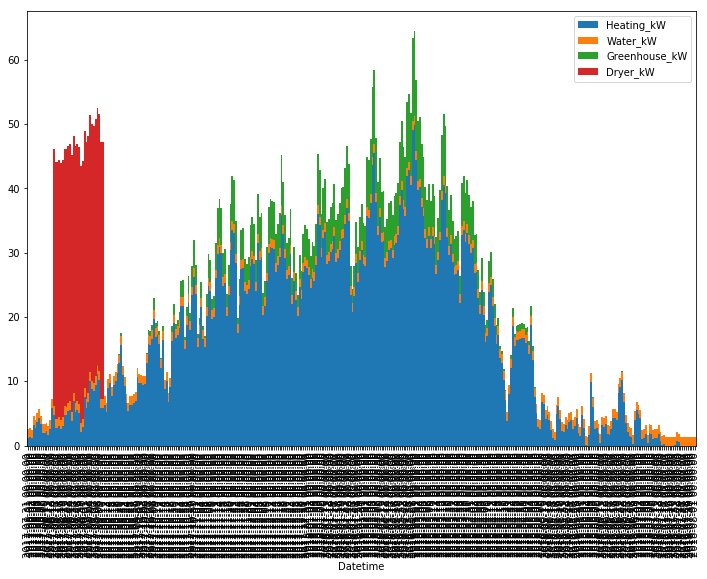

In [18]:
year_period=[2016,2017]
combined.loc['2017-07-31':'2018-08-01'].resample('D').mean().plot.bar(stacked=True,
                                                                        width=1.0, figsize=(12,8))

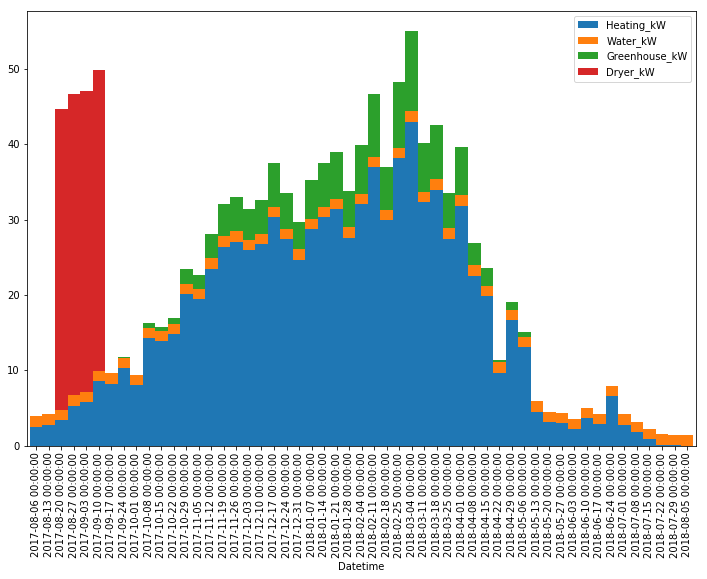

In [19]:
combined.loc['2017-07-31':'2018-08-01'].resample('D').mean().resample('W').mean().plot.bar(stacked=True,width=1.0,
                                                                                         figsize=(12,8))

### Run & plot

In [22]:
H_C_ex, ON_C_ex, BC_C_ex, PC_C_ex = biochar_expansion(combined, 
                                                      C=50, PL=0.5, MINOPS=7,
                                                      year=['2016','2017'],
                                                      calendar=False)

In [23]:
H_C_ex, ON_C_ex, BC_C_ex, PC_C_ex 

([160.15527833792137, 181.72601711373963, 208.60601711373963],
 [0.29863013698630136, 0.3643835616438356, 0.4438356164383562],
 [7.025391081364159, 9.73045285640494, 12.380107515927097],
 [0.5035953158622523, 0.6198337644035412, 0.687538992818422])

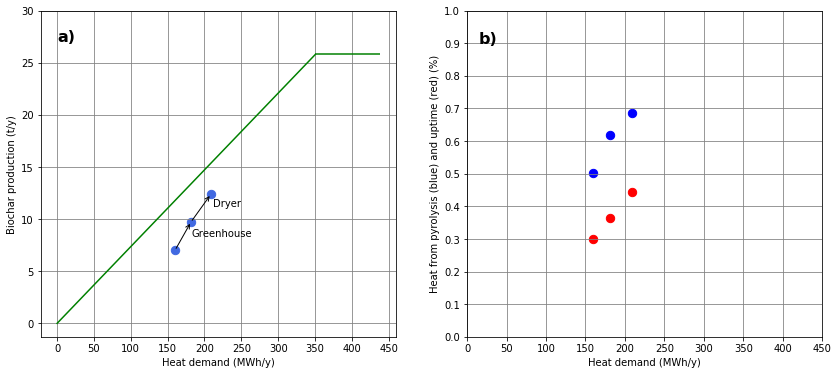

In [24]:
max_bc = 8760*1*50/1000*0.073627160241333
max_ht = 8760*1*50/1000

fig, ax = plt.subplots(1, 2, figsize=(14,6))
pos=['a)','b)']

ax[0].scatter(H_C_ex, np.array(BC_C_ex), marker='o', color='royalblue', s=70) # biochar
ax[0].hlines(y=max_bc*0.8, xmin=max_ht*0.8, xmax=max_ht, colors='green')

x0 = np.array([0,max_ht*0.8])
ax[0].plot(x0, [0,max_bc*0.8], '-', c='green')

major_ticks = np.arange(0, max_ht+50, 50)
ax[0].set_xticks(major_ticks)
major_ticks = np.arange(0, 0.8*max_bc+5, 5)
ax[0].set_yticks(major_ticks)
ax[0].grid(which='both')
ax[0].grid(True, color='grey')
ax[0].set(xlabel='Heat demand (MWh/y)', ylabel='Biochar production (t/y)')    
ax[0].annotate(pos[0], color='black', weight='bold', fontsize=16, xy=(0.05,27))

# Annotations
i=0
fig = ax[0].annotate('', 
             xy=(H_C_ex[i], BC_C_ex[i]), xycoords='data',
             xytext=(H_C_ex[i+1], BC_C_ex[i+1]), textcoords='data',
             arrowprops={'arrowstyle': '<-'})
ax[0].annotate(
    'Greenhouse', xy=(H_C_ex[i+1], 0.5*(BC_C_ex[i]+BC_C_ex[i+1])), xycoords='data',
    xytext=(0, 0), textcoords='offset points')
i=1
fig = ax[0].annotate('', 
             xy=(H_C_ex[i], np.array(BC_C_ex[i])), xycoords='data',
             xytext=(H_C_ex[i+1], np.array(BC_C_ex[i+1])), textcoords='data',
             arrowprops={'arrowstyle': '<-'})
ax[0].annotate(
    'Dryer', xy=(H_C_ex[i+1], 0.5*(BC_C_ex[i]+BC_C_ex[i+1])), xycoords='data',
    xytext=(2, 2), textcoords='offset points')



ax[1].scatter(H_C_ex, PC_C_ex, marker='o', color='blue', s=70) # pyro coverage
ax[1].scatter(H_C_ex, ON_C_ex, marker='o', color='red', s=70) # pyro coverage

major_ticks = np.arange(0, max_ht+50, 50)
ax[1].set_xticks(major_ticks)
major_ticks = np.arange(0, 1+0.1, 0.1)
ax[1].set_yticks(major_ticks)
ax[1].grid(which='both')
ax[1].grid(True, color='grey')
ax[1].set(xlabel='Heat demand (MWh/y)', ylabel='Heat from pyrolysis (blue) and uptime (red) (%)')    
ax[1].annotate(pos[1], color='black', weight='bold', fontsize=16, xy=(15,0.90))

plt.show()

### Run Ficus & Brightway analysis

In [25]:
# Year to study
year='2017'
calendar=False
scenario = 'BioMaCon50kW_PL5MO7_expanded'


In [26]:
# farm_demand is here the variable 'combined'

# plants parsed and ficus file written
farm_supply = fs.run_scn_ficus_writer(plants_folder, plants_file,
                                      tb, tb_start, tb_end, 
                                      calendar,
                                      commodities_imp, commodities_exp, import_max, export_max, 
                                      el_folder, el_file, el_tab, 
                                      ef_pellets, biochar_seq, 
                                      plantsAvailable, combined, year, elec_yr,
                                      afp, ficus_files, scenario)
# run ficus milp
prob = ff.run_ficus(afp+ficus_files+scenario+'.xlsx', opt = 'cplex', MipGap = 0)

# saving ficus report and figures
result_dir = ff.prepare_result_directory(afp+ex+'/output_files', scenario)
ff.report(prob, result_dir)
ff.result_figures(result_dir,prob=prob, show=False)

# printing final report and bw2-LCA
lci_t, lcia_t = fb.run_scn_bw2(result_dir, 'result-'+scenario+'.xlsx',
                                year, calendar, p2e, plantsAvailable,
                                afp, ficus_files, scenario,
                                proj, fg_db, fresh_db=False,
                                plantEmissions=True, plantManufacturing=True, show_plot = False)

Parsing sample_plants
Calculating data for ficus input folder
Writing ficus input file


C:\Users\eazzi\AppData\Local\conda\conda\envs\bw2\lib\site-packages\openpyxl\worksheet\_reader.py:296: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\Users\eazzi\AppData\Local\conda\conda\envs\bw2\lib\site-packages\openpyxl\worksheet\_reader.py:296: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


Read Data ...

Data Read. time: 0.1 s

Prepare Data ...

Data Prepared. time: 0.0 s

Define Model ...

Model Defined. time: 1.5 s

Solve Model ...


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 12.8.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2017.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\eazzi\AppData\Local\Temp\tmp6lkjxsv6.cplex.log' open.
CPLEX> New value for default parallel thread count: 2
CPLEX> Problem 'C:\Users\eazzi\AppData\Local\Temp\tmp11cgs8xz.pyomo.lp' read.
Read time = 0.01 sec. (0.37 ticks)
CPLEX> Problem name         : C:\Users\eazzi\AppData\Local\Temp\tmp11cgs8xz.pyomo.lp
Objective sense      : Minimize
Variables            :    2943  [Nneg: 2935,  Free: 8]
Objective nonzeros   :       8
Linear constraints 

C:\Users\eazzi\Box Sync\KTH_PhD_HeavyData\P2_farm_biochar\ex1_Lindeborg\..\farm_biochar_model\farm_ficus.py:2202: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  sp_crtd = ax0.stackplot(step_edit_x(created.index), step_edit_y(created.as_matrix().T), linewidth=0.15)
C:\Users\eazzi\Box Sync\KTH_PhD_HeavyData\P2_farm_biochar\ex1_Lindeborg\..\farm_biochar_model\farm_ficus.py:2212: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  sp_csmd = ax0.stackplot(step_edit_x(consumed.index), step_edit_y(-consumed.as_matrix().T), linewidth=0.15)
No handles with labels found to put in legend.


Compile ficus lci and lcia
9.641462515029032 ton CO2-eq, net score, for 1 year of farm-energy
Towards bw2...
bw2# Add production processes, manufacturing, and start-ups
bw2# Add technosphere and biosphere flows to each production process
## bw2 Calculate apparent mix for ... el. heater
Current project is:  cs1_Lindeborgs
Read only mode:  False


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 03/18/2020 18:08:53
  Finished: 03/18/2020 18:08:53
  Total time elapsed: 00:00:00
  CPU %: 61.70
  Memory %: 2.48
Scenario  BioMaCon50kW_PL5MO7_expanded  is now ready for analysis in Activity-Browser
